## Στοιχεία Ομάδας

Αριθμός Ομάδας: Μ.Α.11

    > Καρυπιάδης Ευστράτιος: 03114911

In [1]:
import warnings
warnings.filterwarnings('ignore')

---

## 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="85%">

---

### Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [1]:
import pandas as pd

dataset_url = 'data/movieDBe.csv'
df_data_1 = pd.read_csv(dataset_url, sep='\t', header=None, quoting=3, error_bad_lines=False)

Θα δουλέψουμε σε ένα υποσύνολο 5.000 ταινιών ανάλογα με το seed της ομάδας μας:

In [2]:
import numpy as np

# Seed Number: 11
team_seed_number = 11

movie_seeds_url = 'data/seeds2019.csv'
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

my_index = df_data_2.iloc[team_seed_number, :].values

titles = df_data_1.iloc[:, [2]].values[my_index]
categories = df_data_1.iloc[:, [3]].values[my_index]
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index]
summaries =  df_data_1.iloc[:, [5]].values[my_index] 
corpus = summaries[:, 0].tolist() # list form of summaries

- Ο πίνακας `titles` περιέχει τους τίτλους των ταινιών.

- O πίνακας `categories` περιέχει τις κατηγορίες της ταινίας υπό τη μορφή string. Παρατηρούμε ότι είναι μια comma-separated λίστα strings, με κάθε string να είναι μια κατηγορία.

- Ο πίνακας `catbins` περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή μέσω *One-Hot-Encoding*.

- Ο πίνακας `summaries` και η λίστα `corpus` περιλαμβάνουν τις συνόψεις των ταινιών με την corpus είναι ο πίνακας summaries σε μορφή λίστας. Κάθε σύνοψη είναι σε μορφή string.

- Θεωρούμε ως `id` της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας.

Στη συνέχεια της άσκησης θα υλοποιήσουμε ένα *Content Based Recommender System*.

---

### Μετατροπή σε TF - IDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψουμε το corpus σε αναπαράσταση *Term Frequency-Inverse Document Frequency (TF-IDF)*:

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

Σημειώνουμε πως η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ δεν είναι βελτιστοποιημένη.

In [24]:
corpus_tf_idf.shape

(5000, 48526)

---

### Υλοποίηση Συστήματος Συστάσεων

Θα δημιουργήσουμε τη συνάρτηση `content_recommender` με ορίσματα `target_movie` και `max_recommendations`. Πιο συγκεκριμένα, θα υπολογίζουμε για κάθε ταινία-στόχο την [ομοιότητα συνημιτόνου](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) από το `corpus_tf_idf` με όλες τις υπόλοιπες ταινίες, ενώ στη συνέχεια θα ταξινομούμε τις αντίστοιχες ομοιότητες ως προς το *index* της εκάστοτε ταινίας. Η συνάρτησή μας θα επιστρέφει το id, τον τίτλο, την κατηγορία και τη σύνοψη τόσο της ταινίας-στόχου, όσο και των `max_recommendations` συναφών ταινιών.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

def content_recommender(target_movie, max_recommendations):
    """ Returns ID, Title, Genre and Summary of target_movie and #max_recommendation movies respectively. 
    Metric used: Cosine Similarity. """
    
    distances = np.zeros((corpus_tf_idf.shape[0]))
    for i in range(corpus_tf_idf.shape[0]):
        distances[i] = cosine_similarity(corpus_tf_idf[target_movie], corpus_tf_idf[i])
        
    distances_slices = np.argsort(distances) # ascending order of indexes
    distances_slices_descending = distances_slices[::-1]
    
    result = distances_slices_descending[:max_recommendations+1]
    
    for movie in result:
        yield("ID: " + str(movie) +" - Movie Title: " + titles[movie][0] + " - Genre: " + categories[movie][0] + "\n" + summaries[movie][0] + "\n\n")

Θα δοκιμάσουμε τη συνάρτηση στην ταινία [The Dog Who Saved Christmas](https://imdb.to/38BJZrZ):

In [25]:
for recommendation in content_recommender(3763, 5):
    print(recommendation)

ID: 3763 - Movie Title: The Dog Who Saved Christmas - Genre: "Family Film",  "Children's/Family",  "Comedy",  "Holiday Film",  "Television movie"
Zeus, a Labrador Retriever and a former police dog, has lost his bark after his barking ended up blowing off a five-year investigation and his partner can't shoot straight again and ends up at the pound. He is adopted by George Bannister as both an early Christmas present and as a good guard dog for the house, but the mom is hesitant and didn't want a dog. The dog is left alone on Christmas Eve when the family head off to visit Grandma's house. A pair of burglars, Ted Stein and Stewey McMann break into the family home, and it is up to Zeus to save Christmas for his new family by setting up booby traps to stop them. Zeus soon gets caught by the burglars and they muzzle him and continue to rob the house. Zeus escapes and gets them knocked out by dropping a chandelier on them. The police come and arrest Ted and Stewey and Zeus finally barks. The

Παρατηρούμε ότι το συστήμά μας δεν επιστρέφει πλήρως συναφείς ταινίες ως προς το βασικό περιεχόμενο της ταινίας-στόχου. Πιο συγκεκριμένα, φαίνεται πως για κάποιες ταινίες έχει στηριχτεί σε ονόματα χαρακτήρων, μία συμπεριφορά η οποία σε γενικές γραμμές δεν είναι επιθυμητή. Επίσης, αξίζει να σημειώσουμε και τη διαφοροποίηση που παρατηρείται σε σχέση με την κατηγορία της ταινίας εισόδου και εκείνων των προτεινόμενων επιλογών.

Στη συνέχεια θα προσπαθήσουμε να βελτιώσουμε το σύστημα συστάσεών μας προς διόρθωση των παραπάνω στοιχείων.

---

### Βελτιστοποίηση

Προς βελτίωση της συνάρτησης συστάσεων θα εισάγουμε αρχικά το σύνολο `stopwords`, μέσω του οποίου θα φιλτράρουμε το συνολικό μας `corpus`, ώστε να εξάγουμε από αυτό λέξεις με υψηλή συχνότητα εμφάνισης που σε γενικές γραμμές δεν είναι αντιπροσωπευτικές του βασικού περιεχομένου μίας ταινίας:

In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)

stopwords_acc = stopwords.words('english')

Στη συνέχεια θα ακολουθήσουμε τη διαδικασία [Stemming](https://en.wikipedia.org/wiki/Stemming). Για αυτό το σκοπό θα χρησιμοποιήσουμε τον `SnowballStemmer`. Αποτέλεσμα της διαδικασίας θα είναι η λίστα `corpus_stem`, η οποία βρίσκεται στην ακριβώς ίδια μορφή με την αρχική λίστα `corpus`, με μοναδική διαφορά εκείνη των επεξεργασμένων λέξεων. Σημειώνουμε ότι θα περάσουμε και το σύνολο `stopwords_acc` από τον `SnowballStemmer`, ώστε να είναι αποδοτική η μελλοντική μετατροπή του `corpus_stem` σε `corpus_tf_idf`.

In [7]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

corpus_stem_split = [[stemmer.stem(word) for word in summary.split(" ")] for summary in corpus]
corpus_stem = [" ".join(sentence) for sentence in corpus_stem_split]

stopwords_acc_stem = [stemmer.stem(word) for word in stopwords_acc]

Σε αυτό το σημείο ολοκληρώσαμε τη διαδικασία της προεπεξεργασίας των δεδομένων μας. Θα συνεχίσουμε με τη βελτιστοποίηση του `TfidfVectorizer`. Πιο συγκεκριμένα, δε θα χρειαστούμε το όρισμα `lowercase`, καθώς οι λέξεις μας αποτελούνται ήδη από πεζά γράμματα έπειτα από τη διαδικασία *Stemming*. Τελικά, αρκεί να πειραματιστούμε με διαφορετικές τιμές για το ορίσματα `max_df` και `min_df`. Το πρώτο όρισμα θα αγνοεί όρους που εμφανίζονται σε περισσότερες από 1750 περιγραφές ταινιών, ενώ το δεύτερο θα ξεσκαρτάρει όρους που εμπεριέχονται σε μόλις 125 συνόψεις. 

In [26]:
import joblib

vectorizer = TfidfVectorizer(stop_words=stopwords_acc_stem, max_df=0.35, min_df=125)

vectorizer.fit(corpus_stem)
corpus_tf_idf = vectorizer.transform(corpus_stem)

# Saving corpus_tf_idf
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']

In [27]:
corpus_tf_idf.shape

(5000, 895)

Παρατηρούμε ότι η παραπάνω προσέγγιση μειώνει τα χαρακτηριστικά μας από περίπου 48.500 σε 895.

---

### Επεξήγηση Επιλογών, Ποιοτική Ερμηνεία και Παρατηρήσεις

Οι τιμές στις οποίες καταλήξαμε για τα ορίσματα `max_df` και `min_df` είναι 35% και 125, αντίστοιχα. Οδηγηθήκαμε σε αυτόν τον συνδυασμό τιμών, αφού πρώτα εξασφαλίσαμε την επιστροφή προτεινόμενων ταινιών με κοινό πυρήνα υπόθεσης ή περιβάλλοντος. Έπειτα, κινηθήκαμε σε γειτονικές περιοχές του διαστημάτος αυτού, με σκοπό τη βελτιστοποίηση των κατηγοριών που επιστρέφονται, οι οποίες προσπαθήσαμε να βρίσκονται όσο πιο κοντά γίνεται σε εκείνη της ταινίας-στόχου.

Στη συνέχεια παραθέτουμε 10 παραδείγματα ταινιών, για τις οποίες η συνάρτησή μας επιστρέφει ικανοποιητικά συναφή αποτελέσματα:

| Id | Movie Title | Θεματική |
| :---: | :---: | :---: |
| 53 | Five Fingers of Death | fight |
| 205 | They Live by Night  | bank |
| 428 | All About Love | love |
| 1098 | Hiroshima | war |
| 1263 | Live Evil | blood |
| 1504 | Rock 'n' Roll High School | school, student |
| 2081 | War of the Planets | crew |
| 3235 | Meatballs 4 | camp |
| 3763 | The Dog Who Saved Christmas | dog |
| 4695 | Pilot no. 5 | mission | 

Αξίζει ωστόσο να σημειώσουμε ότι αν και το σύστημά μας επιστρέφει πράγματι συναφείς ως προς το περιεχόμενο ταινίες για τα παραπάνω παραδείγματα, δεν παρουσιάζει την ίδια επιθυμητή συμπεριφορά για όλο το σύνολο των δεδομένων μας. Επίσης, παρουσιάζει αδυναμίες σε ότι αφορά τις κατηγορίες των ταινιών, αφού είναι εντελώς εφικτό με είσοδο μία ταινία *Animation* να επιστρέψει ταινία *Horror*. 

Οι αδυναμίες του συστήματός μας θα μπορούσαν να οφείλονται στην ποιότητα του *dataset*, καθώς παρατηρούμε ότι αρκετές ταινίες χαρακτηρίζονται από σύντομες συνόψεις, οι οποίες δεν επιτρέπουν την επαρκή σκιαγράφηση της θεματικής τους ενότητας. Τέλος, είναι επίσης πιθανό κατά την βελτιστοποίηση του `TfidfVectorizer` είτε να αγνοήσαμε σημαντικά πολλούς όρους, είτε να χρειαζόταν να αφαιρέσουμε περισσότερους.

---

## 2. Τοπολογική και σημασιολογική απεικόνιση ταινιών με χρήση SOM

<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="50%" height="50%">

---

### Δημιουργία dataset

Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των [Self Organizing Maps-(SOM)](https://bit.ly/2ughnFu) για να φτιάξουμε ενά χάρτη δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η συνάρτηση `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση *TF-IDF* της εξόδου της `TfidfVectorizer()` σε πυκνή. Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον χαρακτηριστικά. Συνεπώς, κάθε ταινία αναπαρίσταται στο *Vector Space Model* από τα χαρακτηριστικά του *TF-IDF* και τις κατηγορίες της.

In [0]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit, :]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit, :]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [0]:
final_set = build_final_set()

In [150]:
final_set.shape

(5000, 11236)

Προς μείωση της διαστατικότητας της εφαρμογής μας θα περάσουμε τα δεδομένα μας από τη διαδικασία της [Principal Component Analysis-(PCA)](https://bit.ly/379Ut1i). Σαν όρισμα `n_components` θα περάσουμε τον πραγματικό αριθμό 0.85, ο οποίος αντιστοιχεί στο ποσοστό της διακυμάνσης που επιθυμούμε να διατηρήσουμε:

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.85)
final_set = pca.fit_transform(final_set)

In [152]:
final_set.shape

(5000, 659)

---

### Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη [Somoclu](https://bit.ly/361xnsk) και πιο συγκεκριμένα με χάρτη τύπου *planar* και παραλληλόγραμο σχήμα νευρώνων με τυχαία αρχικοποίηση. Στην εκπαίδευση θα επιλέξουμε 100 `epochs`.

Σημειώνουμε ότι προς μελλοντική εκοικονόμηση χρόνου και υπολογιστικής ισχύος θα αποθηκεύσουμε τον εκπαιδευμένο χάρτη.

In [142]:
import somoclu

rows, columns = 25, 25 
som = somoclu.Somoclu(columns, rows, kerneltype=1, compactsupport=False)

%time som.train(data=final_set, epochs=100)

# Saving trained SOM 
joblib.dump(som, 'som.pkl')

CPU times: user 29min 52s, sys: 2.22 s, total: 29min 54s
Wall time: 15min 35s


In [0]:
som = joblib.load('som.pkl')

---

### Best Matching Units

Στη συνέχεια θα αποθηκεύσουμε τα μοναδικά *Best Matching Units* και τους αντίστοιχους δείκτες τους στις ταινίες με χρήση της [np.unique](https://bit.ly/2RtVFGd):

In [221]:
bmus_array, bmus_indices = np.unique(som.bmus, axis=0, return_inverse=True)

bmus_array.shape

(498, 2)

Παρατηρούμε ότι τα *bmus* είναι μικρότερα από το πλήθος των νευρώνων που επιλέξαμε, καθώς σε 127 από αυτούς δεν ανατέθηκε κάποια ταινία.

---

### Οπτικοποίηση U-matrix, Clustering και Μέγεθος Clusters

Προς οπτικοποίηση του *U-matrix* θα χρησιμοποιήσουμε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(12, 12)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά *clusters* που προκύπτουν από τον [K-Means](https://bit.ly/2R7TM2Z), τον αλγόριθμο που επιλέξαμε για την ομαδοποίηση των νευρώνων.

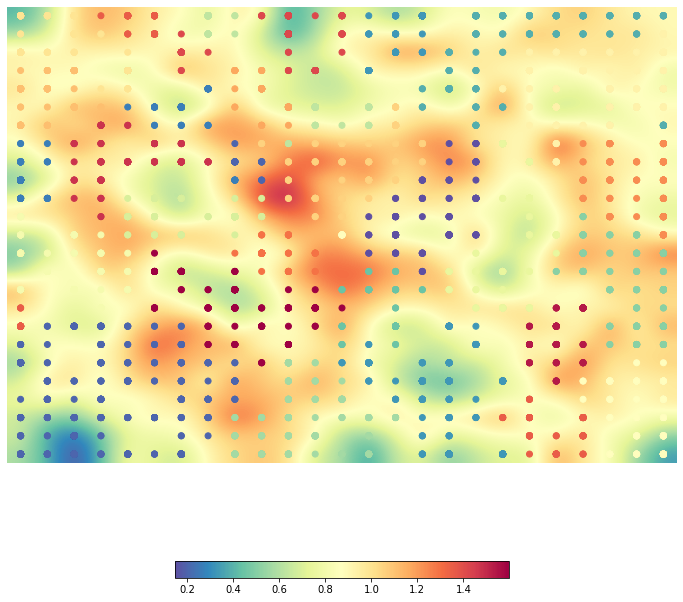

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [155]:
import matplotlib
from sklearn.cluster import KMeans

%matplotlib inline

clustering = KMeans(n_clusters=25)
som.cluster(algorithm=clustering)

som.view_umatrix(bestmatches=True, colorbar=True, figsize=(12, 12))

Για μια δεύτερη και πιο ξεκάθαρη οπτικοποίηση του *clustering* θα τυπώσουμε απευθείας τη μεταβλητή `som.clusters`. Για αισθητικούς λόγους θα μετατρέψουμε τον δισδιάστατο πίνακα σε *DataFrame*, καθώς το πλήθος των νευρώνων δεν επιτρέπει στοιχισμένη απεικόνιση:

In [217]:
acc = [i for i in range(1, 26)]

clust_df = pd.DataFrame(som.clusters, columns=acc, index=acc)
clust_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
1,14,14,14,20,20,20,8,8,8,21,21,21,21,3,3,3,3,4,4,4,4,4,4,4,4
2,14,14,14,14,20,20,21,8,8,21,21,21,21,3,3,3,4,4,4,4,4,4,4,4,13
3,14,14,14,14,14,20,21,21,17,21,21,21,21,3,3,3,4,4,4,13,13,13,13,13,13
4,16,16,16,14,14,14,21,17,17,17,21,21,21,3,3,3,4,4,13,13,13,13,13,13,13
5,16,16,16,14,14,2,2,2,17,17,17,8,8,8,3,4,4,4,13,13,13,13,13,13,13
6,16,16,16,16,2,2,2,2,17,17,17,8,8,8,15,4,4,4,4,13,13,13,13,13,13
7,16,16,16,22,22,2,2,2,17,17,17,8,8,8,15,15,4,4,4,13,13,13,13,13,4
8,2,2,22,22,22,22,22,22,1,15,8,15,15,15,15,15,0,0,10,10,13,18,18,18,18
9,2,2,22,22,22,22,22,22,1,1,15,15,15,15,15,15,0,0,10,10,13,18,18,18,18
10,2,2,22,22,22,9,9,9,2,1,15,15,15,15,15,0,0,0,10,10,18,18,18,18,18


Τέλος, θα εμφανίσουμε τις ετικέτες των *clusters* με αύξουσα σειρά ως προς τον αριθμό των νευρώνων:

In [248]:
cluster_vals, cluster_counts = numpy.unique(som.clusters, return_counts=True)
x = dict(zip(cluster_vals, cluster_counts))

l1, l2 = [], []

a = {k: v for k, v in sorted(x.items(), key=lambda x: x[1])}
for key, value in a.items():
  l1.append(key)
  l2.append(value)

final_frame = pd.DataFrame(np.vstack((np.array(l1), np.array(l2))), columns=[i for i in range(1, 26)], index = ["Cluster Index", "Number of Neurons"])
final_frame

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Cluster Index,19,23,16,17,5,8,14,2,21,9,20,22,18,12,11,0,15,6,7,10,4,13,24,3,1
Number of Neurons,11,12,13,13,15,15,17,19,19,20,20,20,21,22,25,26,26,27,31,31,32,34,34,53,69


---

### Σημασιολογική Ερμηνεία των Clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

---

### Ανάλυση Τοπολογικών Ιδιοτήτων του SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.



Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.
